# Courbes de niveau

## Table des matières

- Préambule

  - Dépendances logicielles

  - Différentiation automatique

- Ensembles de niveau : exemples de référence

- Construction des courbes de niveau

  - Méthode de Newton

  - Génération des points

  - Bouclage et auto-intersection 

- Calcul de l'aire d'un ensemble de sous-niveau

  - Méthode des carrés

  - Méthodes des triangles

## Préambule

### Dépendances logicielles 

In [58]:
# Autograd & Numpy
import autograd
import autograd.numpy as np

# Pandas
import pandas as pd

# Matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [5, 5] # [width, height] (inches). 

# Jupyter & IPython
from IPython.display import display

### Différentation automatique

On définit ici deux fonctions utilitaires, `grad` et `J`, permettant de calculer simplement le gradient d'une fonction scalaire de deux variables réelles et la matrice jacobienne d'une fonction vectorielle de deux variables réelles.

In [59]:
def grad(f):
    g = autograd.grad
    def grad_f(x, y):
        return np.array([g(f, 0)(x, y), g(f, 1)(x, y)])
    return grad_f

In [60]:
def J(f):
    j = autograd.jacobian
    def J_f(x, y):
        return np.array([j(f, 0)(x, y), j(f, 1)(x, y)]).T
    return J_f

Exemples d'usage :

In [61]:
def f(x, y):
    return np.sin(x) + 2.0 * np.sin(y)

grad_f = grad(f)

grad_f(1.0, 0.0) # array([1., 2.])
#g = autograd.grad
#print(g(f,0)(0.0,0.0))

array([0.54030231, 2.        ])

In [62]:
def f(x, y):
    return np.array([x + 2 * y, 3 * x + 4 * y])

J_f = J(f)

J_f(0.0, 0.0) # array([[1., 2.], [3., 4.]])

array([[1., 2.],
       [3., 4.]])

## Ensembles de niveau : exemples de référence

On appelle *ensemble de niveau* $c \in \mathbb{R}$ d'une fonction $f : \mathbb{R}^2 \to \mathbb{R}$  l'ensemble du plan
$$
\{(x,y) \in \mathbb{R}^2 \; | \; f(x, y) = c\}.
$$


On définit ici quelques fonctions qui pourront servir de référence pour valider les algorithmes de génération de courbes de niveau. On pourra également utiliser la fonction utilitaire `display_contour` ci-dessous, qui exploite [la fonction `contour` de Matplotlib](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.contour.html) pour représenter une collection d'ensembles de niveau.

In [63]:
def display_contour(f, x, y, levels):
    X, Y = np.meshgrid(x, y)
    Z = f(X, Y)
    fig, ax = plt.subplots()
    contour_set = plt.contour(
        X, Y, Z, colors="grey", linestyles="dashed", 
        levels=levels 
    )
    ax.clabel(contour_set)
    plt.grid(True)
    plt.xlabel("$x_1$") 
    plt.ylabel("$x_2$")
    plt.gca().set_aspect("equal")

#### Fonction quadratique

In [64]:
def f1(x, y):
    x = np.array(x)
    y = np.array(y)
    return 3.0 * x * x - 2.0 * x * y + 3.0 * y * y 

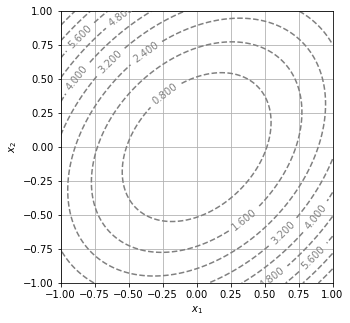

In [65]:
display_contour(
    f1, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=10 # 10 levels, automatically selected
)

#### Fonction de Rosenbrock

Source : [Fonction de Rosenbrock, Wikipédia](https://en.wikipedia.org/wiki/Rosenbrock_function)

$$
f_2 : (x,y) \in \mathbb{R}^2 \mapsto (x - 1)^2 + (x - y^2)^2
$$

In [66]:
def f2(x, y):
    return (x - 1)**2 + (x - y**2)**2

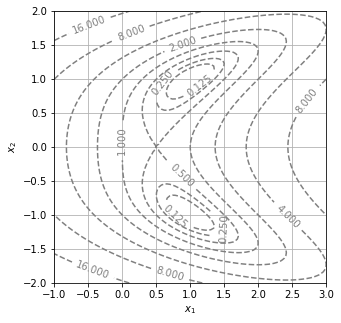

In [67]:
display_contour(
    f2, 
    x=np.linspace(-1.0, 3.0, 100), 
    y=np.linspace(-2.0, 2.0, 100), 
    levels=[2**i for i in range(-3, 8)] # levels: [0.125, 0.25, ..., 64, 128]
)

#### Fonction complexe

Source: [Courbe implicite, Wikipédia](https://en.wikipedia.org/wiki/Implicit_curve)

In [68]:
def f3(x, y):
    return np.sin(x + y) - np.cos(x * y) - 1 + 0.001 * (x * x + y * y) 

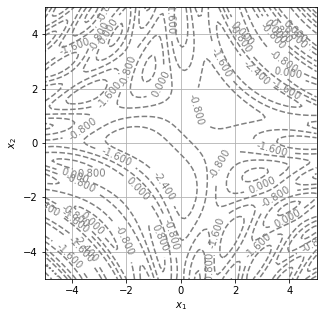

In [69]:
display_contour(
    f3, 
    x=np.linspace(-5.0, 5.0, 100), 
    y=np.linspace(-5.0, 5.0, 100), 
    levels=5, # 5 levels, automatically selected
)

## Construction des courbes de niveau

### Méthode de Newton

Afin de trouver des points sur des courbes de niveau, on souhaite implémenter un algorithme de résolution des équations de la forme $F(x,y) = 0$ où $F: \mathbb{R}^2 \to \mathbb{R}^2$, par la méthode de Newton, amorcée par un point de référence $(x_0,y_0) \in \mathbb{R}^2$.

L'implémentation prendra la forme générale donnée ci-dessous. L'appel `x, y = Newton(F, x0, y0, eps, N)` devra renvoyer le couple des coordonnées d'un point $(x, y)$ qui est une solution approchée de $F(x,y)=0$ à proximité de $(x_0, y_0)$. La qualité de l'approximation produite est déterminée par le réel positif $\varepsilon > 0$, une approximation de la distance entre le point $(x,y)$ renvoyé par la fonction et la solution exacte. L'algorithme itératif s'interrompra si aucune approximation de la précision souhaitée n'a été trouvée en $N$ étapes. 

**Question** L'application à laquelle nous destinons la fonction `Newton` demande-t'elle une grande précision ?
Choisir une valeur de `eps` qui semble raisonnable et justifier l'ordre de grandeur choisi.

**Réponse** Dans la fonction `Newton` on a besoin d'une distance entre deux points. On doit donc avoir $\sqrt{2\epsilon_{ordi}} \leq eps$. Comme plus $eps$ est petit, plus il est compliqué d'arriver à la précision voulue avec l'algorithme `Newton`, on a tout intérêt à ne pas le prendre trop petit non plus. Il n'a pas besoin d'être de l'ordre de $\epsilon_{ordi}$ ; on peut donc prendre 10**-2, par exemple, qui paraît être un bon compromis (suffisamment précis pour que les tracés valent quelque chose, et suffisamment grand pour avoir de bonnes chances d'exécuter nos algorithmes sans avoir besoin d'attendre trop longtemps que les itérations se fassent.



In [70]:
N = 100
eps = 10**-2 

**Question** Implémenter la fonction `Newton` en complétant le canevas ci-dessous

In [71]:

def Newton(F, x0, y0, eps=eps, N=N):
    x = x0
    y =y0
    for i in range(N):
        x1=x
        y1=y
        (x2,y2)=(np.linalg.solve(J(F)(x1,y1),F(x1,y1)))
        x=x1-x2
        y=y1-y2
        if np.sqrt((x - x0)**2 + (y - y0)**2) <= eps:
            return np.array([x, y])
        x0, y0 = x, y
    else:
        raise ValueError(f"no convergence in {N} steps.")


### Illustration avec la fonction f1 en partant du point (0.8,0.8) puis (0.5,0.8)

**Question** Tester votre implémentation de la fonction `Newton` ! On suggère par exemple de l'utiliser pour chercher un point $(x, y)$ de la ligne de niveau $0.8$ de $f_1$ (cf. Exemples de référence) qui vérifie en outre $x = y$ en utilisant le point $(0.8, 0.8)$. Puis de faire varier le point de référence, la contrainte supplémentaire, etc. et de représenter graphiquement les résultats.

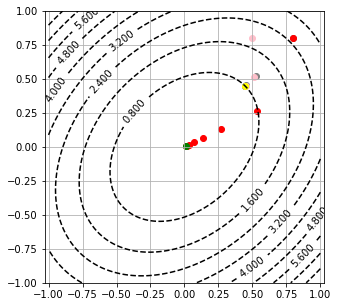

In [72]:
def F1(x,y): #il faut passer de f1:R2->R à F1:R2->R2 pour faire appel 
    #à la jacobienne. Pour ça on rajoute une contrainte, par ex x=y
    x1=f1(x,y)-0.8
    y1=x-y
    return np.array([x1,y1])

def F1bis(x,y):
    x1=f1(x,y)
    y1=x-2*y
    return np.array ([x1,y1])

#On crée un algo qui donne la liste des points intermédiaires
#avant d'arriver à la solution
def Newtonbis(F, x0, y0, eps=eps, N=N):
    x = x0
    y =y0
    X=[x]
    Y=[y]
    for i in range(N):
        x1=x
        y1=y
        (x2,y2)=(np.linalg.solve(J(F)(x1,y1),F(x1,y1)))
        x=x1-x2
        y=y1-y2
        X.append(x)
        Y.append(y)
        if np.sqrt((x - x0)**2 + (y - y0)**2) <= eps:
            return X,Y
        x0, y0 = x, y
    else:
        raise ValueError(f"no convergence in {N} steps.")

X,Y = Newtonbis(F1,0.8,0.8) #On récupère les points pour la condition x=y
plt.scatter(X,Y,c='grey') #On trace les points
plt.scatter(X[-1],Y[-1],c='b') #Tracage du point final

#Idem pour la condition x=2y:
X1,Y1 = Newtonbis(F1bis,0.8,0.8)
plt.scatter(X1,Y1,c='r')
plt.scatter(X1[-1],Y1[-1],c='g')

X2,Y2=Newtonbis(F1,0.5,0.8) #Idem pour x=y en partant de (0.5,0.8)
plt.scatter(X2,Y2,c='pink')
plt.scatter(X2[-1],Y2[-1],c='yellow')

# On trace les lignes de niveau
X0,Y0 = np.linspace(-1,1,1000),np.linspace(-1,1,1000) 
X0,Y0 = np.meshgrid(X0,Y0)
Z0 = f1(X0,Y0)
Res = plt.contour(X0,Y0,Z0,linestyles = 'dashed',colors = 'black',levels = 12) 
plt.clabel(Res);



plt.xlim([-1,1]);
plt.ylim([-1,1]);
plt.axis('equal');
plt.grid()

### Génération des points

**Question** Comment, en partant d'un point de référence $(x_0, y_0)$ tel que $f(x_0, y_0)=c$, peut-on générer avec la méthode de Newton un point $(x_1, y_1)$ également tel que $f(x_1, y_1) = c$, mais à une distance $\delta > 0$ de $(x_0, y_0)$ et qui soit "à droite" quand on est en $(x_0, y_0)$ et qu'on regarde dans la direction de $\nabla f(x_0, y_0)$ ? Implémenter la fonction `level_curve` qui répète ce procédé $N-1$ fois et renvoie un tableau NumPy de taille $2 \times N$ contenant les coordonnées des points correspondants.

**Réponse** : On nous donne $\delta > 0$. 
On a un point de référence $ \vec x_0 = (x_0,y_0)$ tel que $f(x_0,y_0) = c$. 
Comme le produit scalaire de $f(x)$ et de son gradient est nul par définition, $\nabla f(x)$ est perpendiculaire à la courbe de niveau en $x$.

On cherche un point $(x_1,y_1)$ vérifiant le système $ \left(\begin{matrix} f(x_1,y_1) = c \\ \|(x_1,y_1) - (x_0,y_0)\| = \delta \end{matrix} \right)$.
Ce point doit être "à droite" quand on regarde dans la direction de $\nabla f(x)$ .

Soit $\vec vecteur = \left(\begin{matrix} \partial_y f(x) \\ -\partial_x f(x) \end{matrix} \right)$. On pose $\vec vecteur normé = \frac{1}{\|\vec vecteur\|} \cdot \vec vecteur$. On a donc $\vec vecteur_normé$ qui est un vecteur tangent à la courbe de niveau en $x$. Posons $(x'_0,y'_0) = (x_0,y_0) + \delta \vec vecteur normé$.

En posant $F(x) = (f(x)-c,\|\vec x_0 - x\| - \delta)$, il suffit de prendre `(x1,y1) = Newton(F,x0,y0)`. 



In [73]:
eps=10**-2
def level_curve(f, x0, y0, N,delta=0.1):
    c=f(x0,y0)
    x,y=x0,y0
    X=[x0]
    Y=[y0]
    for j in range(N):
        # d'abord on trouve le point de départ (a,b)
        g=grad(f)(x,y)
        vecteur=np.array([g[1],-g[0]])
        norme=np.sqrt((vecteur[0])**2+(vecteur[1])**2)
        vecteur_normé=vecteur/norme
        vecteur_delta=vecteur_normé*delta
        (a,b)=(x,y)+vecteur_delta
        def F(x,y,a,b):
            return np.array([f(x,y)-c,np.sqrt((x-a)**2 + (y-b)**2) - delta])
        #ensuite on fait tourner l'algo à partir de (a,b)
        a,b=Newton(lambda c,d : F(c,d,X[-1],Y[-1]),a,b,eps=eps,N=N)
        X.append(a)
        Y.append(b)
        x,y=a,b
    return np.array([X,Y])


#test 
level_curve(f2, 0.0, 0.0, delta=0.1, N=1000)




array([[ 0.00000000e+00,  4.95049505e-05,  7.69518503e-04, ...,
         1.01287984e+00,  1.04290442e+00,  1.08608764e+00],
       [ 0.00000000e+00,  1.00000000e-01,  1.99998775e-01, ...,
        -1.13424505e-01, -2.09177385e-01, -2.99600618e-01]])

### __Illustration avec la fonction f2 pour la courbe f(x) = 1.0__

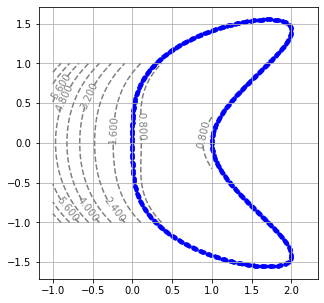

In [74]:


XY=level_curve(f2, 0.0, 0.0, delta=0.1, N=1000)
#Tracage des lignes de niveau
X0,Y0 = np.linspace(-1,1,100),np.linspace(-1,1,100)
X0,Y0 = np.meshgrid(X0,Y0)
Z = f2(X0,Y0)
Res = plt.contour(X0,Y0,Z,linestyles = 'dashed',colors = 'grey',levels = 10)
plt.clabel(Res);

#Tracage des points obtenus
plt.scatter(XY[0,::],XY[1,::],c='b',marker='.');
plt.xlim([-1,1]);
plt.ylim([-1,1]);
plt.axis('equal');
plt.grid()


### Bouclage et auto-intersection

L'algorithme précédent est malheureusement susceptible de faire plusieurs fois le tour d'une courbe de niveau donnée. 

**Question** Proposer une nouvelle implémentation de `level_curve` qui évite ce problème. 

In [75]:
#blabla on fait pareil mais on rajoute une condition : si le k ième terme apparait déjà dans le 
#tableau précédent, c'est niet
def level_curve2(f, x0, y0, N,delta=0.1):
    c=f(x0,y0)
    x,y=x0,y0
    X=[x0]
    Y=[y0]
    for j in range(N):
        # d'abord on trouve le point de départ (a,b)
        g=grad(f)(x,y)
        vecteur=np.array([g[1],-g[0]])
        norme=np.sqrt((vecteur[0])**2+(vecteur[1])**2)
        vecteur_normé=vecteur/norme
        vecteur_delta=vecteur_normé*delta
        (a,b)=(x,y)+vecteur_delta
        def F(x,y,a,b):
            return np.array([f(x,y)-c,np.sqrt((x-a)**2 + (y-b)**2) - delta])
        #ensuite on fait tourner l'algo à partir de (a,b)
        a,b=Newton(lambda c,d : F(c,d,X[-1],Y[-1]),a,b,eps=eps,N=1000)
        #On teste si le point est déjà dans la liste
        bool=False
        for i in range(j):
            if X[i]==[a] and Y[i]==[b]:
                bool = True
                break
        if not bool:
            X.append(a)
            Y.append(b)
        x,y=a,b
        if bool :
            break #inutile de continuer parce que si on est tombé sur un élément
            #déjà dans la liste, ce sera aussi le cas des suivants
    return np.array([X,Y])


**Question** Valider graphiquement le résultat au moyen des exemples de référence.

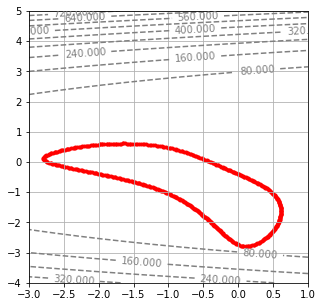

In [76]:
#EXEMPLE f3 pour la courbe f(x) = -2.4, avec x=y

def f(x,y):
    return f3(x,y) + 2.4
def F3(x,y):
    return np.array([f(x,y),x-y])
x,y = Newton(F3,0.0,0.0,1000)
XY = level_curve2(f,x,y,N=500)

X0,Y0 = np.linspace(-3,1,100),np.linspace(-4,5,100)
X0,Y0 = np.meshgrid(X0,Y0)
Z = f2(X0,Y0)
CS = plt.contour(X0,Y0,Z,linestyles = 'dashed',colors = 'grey',levels = 10)
plt.clabel(CS);

plt.scatter(XY[0,::],XY[1,::],c='r',marker='.');
plt.xlim([-3,1]);
plt.ylim([-4,5]);
plt.grid()





# Calcul de l'aire d'un ensemble de sous-niveau
On cherche à estimer l'aire d'un ensemble délimité par une courbe fermée, approchée par une ligne brisée comme les ensemble de niveau décrits précédemment.

## Méthode des carrés
Considérons un tel ensemble $K$ décrit par l'équation $f(x_1,x_2)\leq c$.
Une première approche grossière, sans utiliser la description de la frontière obtenue précédemment, consiste à plonger l'ensemble  $K$ dans un domaine de forme simple (disons un carré pour fixer les idées), donc d'aire connue, à recouvrir le carré d'une grille uniforme constituée de petites cellules carrée de taille $h\times h$,  et d'estimer l'aire en fonction de la proportion du nombre de cellules dont le centre est  dans $K$. On obtient ainsi une approximation $A_h$ de l'aire de $K$. Lorsque $h$ tend vers $0$, on peut  s'attendre à ce que $A_h$ tende effectivement vers l'aire $A$ de $K$. 

**Question**  Coder une fonction `area_squares(f,c,h)` qui renvoie l'aire approchée de l'ensemble de sous-niveau de $f$ associée à $c$ à l'aide de la méthode des carrés pour un pas $h$. Appliquer cette méthode à l'estimation  de l'aire du disque unité et étudier numériquement le comportement de  $|A_h - A|$ quand $h$ tend vers $0$. (On pourra tracer une courbe de l'erreur fonction de $h$ en échelle log-log).

In [77]:
import numpy.random 

def area_squares (f, c, h) :

    # On doit d'abord trouver un point tel que f(x, y) = c
    # On utilise alors la méthode de Newton à un point où le gradient ne s'annule pas
    def fprime (x, y) :
        return np.array([f(x, y) - c, x - y])
        
    xn, yn = 0., 0.
    while grad(f)(xn, yn).any() == 0. :
        xn = np.random.random()
        yn = np.random.random()

    x0, y0 = Newton(fprime, xn, yn)
    
    # On doit maintenant construire l'ensemble K
    K = level_curve(f, x0, y0, 200)

    # On doit maintenant construire le carré autour de K
    x_max, y_max = max(K[0]), max(K[1])
    x_min, y_min = min(K[0]), min(K[1])

    # On fait une grille et on teste si le centre du petit carré est dans K
    area = 0.
    x = x_min + h/2
    y = y_min + h/2
    while x <= x_max :
        while y <= y_max :
            if f(x, y) <= c :
                area += h * h
            y += h 
        x += h
        y = y_min + h/2
        
    return area    

In [78]:
def f4(x, y) :
    return x * x + y * y

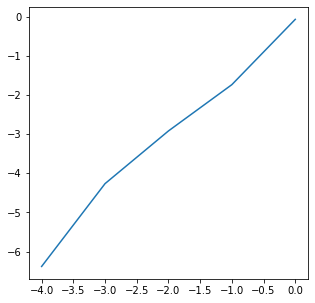

In [129]:
X = [10 ** (-k) for k in range (5)]
Y = [abs(area_squares(f4, 1, h) - np.pi) for h in X]

plt.plot(np.log10(X), np.log10(Y))
plt.show()

# 7min pour tourner

**Réponse** On remarque que l'erreur est quasi linéaire en fonction de h

**Question**  Expliquer comment cette approche peut être modifiée pour obtenir un encadrement de l'aire recherchée. 
Appliquer cette approche à l'ensemble de sous niveau considéré précédemment, pour en donner un encadrement à $10^{-2}$ près.


**Réponse** Pour trouver un encadrement de l'aire, on peut dans un premier temps considérer les carrés dont les 4 coins sont dans l'ensemble de sous-niveaux (on obtient un minorant de cette aire recherchée). Dans un second temps, on ne considère que les carrés dont le centre est inclus dans l'ensemble de sous-niveaux (on obtient alors les carrés dont la frontière peut à priori ne pas être dans l'ensemble de sous-niveaux, et donc un majorant de l'aire recherchée).

In [79]:
def area_squares_minorant (f, c, h) :

    # On doit d'abord trouver un point tel que f(x, y) = c
    # On utilise alors la méthode de Newton à un point où le gradient ne s'annule pas
    def fprime (x, y) :
        return np.array([f(x, y) - c, x - y])
        
    xn, yn = h, h

    x0, y0 = Newton(fprime, xn, yn)
    
    # On doit maintenant construire l'ensemble K
    K = level_curve(f, x0, y0, 200)

    # On doit maintenant construire le carré autour de K
    x_max, y_max = max(K[0]), max(K[1])
    x_min, y_min = min(K[0]), min(K[1])

    # On fait une grille et on teste si le centre du petit carré est dans K
    area = 0
    x = x_min + h/2
    y = y_min + h/2
    while x <= x_max :
        while y <= y_max :
            if f(x + h/2, y + h/2) <= c and f(x + h/2, y - h/2) <= c and f(x - h/2, y + h/2) <= c and f(x - h/2, y - h/2) <= c : # On vérifie la condition pour les 4 coins
                area += h * h
            y += h # On parcourt d'abord les lignes
        x += h # Puis les colonnes
        y = y_min + h/2
    return area    

In [80]:
print(area_squares(f4, 1, 0.001), area_squares_minorant(f4, 1, 0.001))

3.1416460000852284 3.1375600000846573


**Réponse**

$$
3.15 > \pi r^2 > 3.13 
$$

## Méthode des triangles
On suppose maintenant que l'on dispose d'une description approchée de la frontière de l'ensemble $K$, sous la forme d'une suite "circulaire"  de points consécutifs:
$$
(x_0,y_0), (x_1,y_1), \dots, (x_N,y_N)= (x_0,y_0),
$$
par exemple la sortie de ``level_curve``.
On note $z_i = (x_i,y_i)$. Conformément à ce qui précède, on considére que la courbe fermée est décrite dans le sens anti-trigonométrique (sens des aiguilles d'une montre). On suppose dans un premier temps que l'ensemble $K$ est convexe. 
On se donne un point $p = (x_p,y_p)$ dans  l'intérieur de $K$, et l'on somme les aires des triangles $(p,z_{i+1},z_i)$. 
On obtient une approximation de l'aire de $K$, notée $B_N$.

**Question** Tester cette approche sur le disque unité. Etudier la convergence de $B_N$ vers $\pi$ lorsque la distance $\delta$ entre les points successifs de la courbe de niveau tend vers 0, et étudier numériquement la vitesse de cette convergence.  

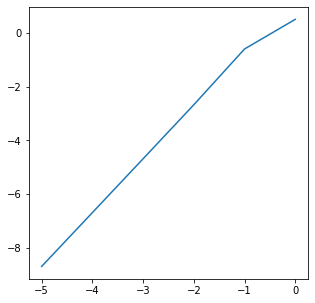

In [128]:
def airedébile (a, b, c): # On calcule directement l'aire orientée du triangle, contrairement à la formule de Héron d'Alexandrie par ex.

        x1, y1 = a[0], a[1]
        x2, y2 = b[0], b[1]
        x3, y3 = c[0], c[1]
        c1 = (y2 - y3)
        c2 = (y3 - y1)
        c3 = (y1 - y2)
        
        return ((x1 * c1 + x2 * c2 + x3 * c3) * 0.5)

# On décrit le cercle unité de cette manière car moins long à exécuter que level_curve2

def K(delta) :
    return [[np.cos(2 * np.pi * x) for x in np.linspace(0, 1, int(1/delta))], [np.sin(2 * np.pi * x) for x in np.linspace(0, 1, int(1/delta))]] 

def area_triangles(p, K) : 
    
    aire = 0

    X, Y = K

    for i in range (len(X) - 1) :

        aire += airedébile(p, (X[i], Y[i]), (X[i + 1], Y[i + 1]))

    aire += airedébile(p, (X[-1], Y[-1]), (X[0], Y[0]))
        
    return aire
    
A = [10 ** (-k) for k in range (0, 6)]
B = [abs(area_triangles((0, 0), K(a)) - np.pi) for a in A]

plt.plot(np.log10(A), np.log10(B))
plt.show()


**Réponse** On remarque une pente de -2 donc on a une convergence en delta au carré

**Question** Vérifier que l'approche (on prendra garde à accepter le fait qu'il puisse y avoir, dans le calcul des différentes aires,  des triangles d'aire négative) donne des résultats pertinents même si le point $p$ est  à l'extérieur de $K$. Donner une explication à ce bon comportement.

In [179]:
def airedébile (a, b, c): 

    x1, y1 = a[0], a[1]
    x2, y2 = b[0], b[1]
    x3, y3 = c[0], c[1]
    c1 = (y2 - y3)
    c2 = (y3 - y1)
    c3 = (y1 - y2)
        
    return ((x1 * c1 + x2 * c2 + x3 * c3) * 0.5)
        

K =  [[np.cos(2 * np.pi * x) for x in np.linspace(0, 1, 5000)], [np.sin(2 * np.pi * x) for x in np.linspace(0, 1, 5000)]]

def area_triangles(p, K) : 
    
    aire = 0

    X, Y = K

    for i in range (len(X) - 1) :

        aire += airedébile(p, (X[i], Y[i]), (X[i + 1], Y[i + 1]))

    aire += airedébile(p, (X[-1], Y[-1]), (X[0], Y[0]))
        
    return aire
    
area_triangles((-3, 0), K) # Ce point est en dehors du disque unité


3.1415918264249756

**Réponse** On trouve bien un résultat proche de $ \pi $

**Question** Vérifier le bon comportement de la méthode dans le cas où l'ensemble $K$ n'est pas convexe. On pourra considérer par exemple la réunion de deux disques, tous deux décrits par leur frontière discrétisée parcourue dans le sans anti-trigonométrique.

In [178]:
L1 = [3 + np.cos(2 * np.pi * x) for x in np.linspace(0, 1, 5000)]
K1 = K[0]
NC1 = K1 + L1
NC2 = K[1] + K[1]
NC = [NC1, NC2] # 

area_triangles((-2, 0), NC)

6.283183652850012

**Réponse** La méthode des triangles fonctionne aussi

**Question** En déduire une fonction `area_triangles(x,y)` qui évalue l'aire d'une surface de niveau décrite par un ensemble de points $(x_i,y_i)$ de la courbe de niveau. Appliquer cette approche à l'ensemble de sous-niveau considéré précédemment, et vérifier que les deux méthodes (carrés et triangles) donnent des résultats cohérents entre elles. 
Comparer les méthodes entre elles, en précisant les avantages et défauts relatifs de chacune d'elles. 
(On pourra appuyer la réponse sur des tests numériques ainsi que sur des arguments théoriques)

In [180]:
def area_triangles(x, y) : # x la liste des xi, y la liste des yi

    aire = 0
    
    for i in range (len(x) - 1) :
        
        aire += airedébile((0, 0), (x[i], y[i]), (x[i + 1], y[i + 1]))

    aire += airedébile((0, 0), (x[-1], y[-1]), (x[0], y[0]))
        
    return aire

In [189]:
x, y = [[2 * np.cos(2 * np.pi * x) for x in np.linspace(0, 1, 5000)], [2 * np.sin(2 * np.pi * x) for x in np.linspace(0, 1, 5000)]]
# Exemple sur le disque centré en (0, 0) et de rayon 2

print(area_squares(f4, 4, 10**-3))
print(area_triangles(x, y))

12.566302997346895
12.566367305700808


**Réponse** On remarque qu'on obtient des résultats cohérents dans les deux cas

$En\ ce\ qui\ concerne\ la\ méthode\ des\ carrés\ :$

Les inconvénients sont la convergence lente en fonction de h (seulement linéaire) et le temps de calcul plutôt conséquent
L'avantage principal est de pouvoir calculer l'aire sans avoir une description précise de la ligne de niveau puisque l'algorithme s'en charge

$En\ ce\ qui\ concerne\ la\ méthode\ des\ triangles\ :$

L'inconvénient principal est la nécessité d'une connaissance très précise de la ligne de niveau 
L'avantage majeur est la convergence quadratique en delta : on obtient facilement et rapidement une bonne approximation du résultat